In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "4" # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "4" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "6" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "4" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "6" # export NUMEXPR_NUM_THREADS=6

import numpy as np

import bilby
from gwpy.timeseries import TimeSeries
logger = bilby.core.utils.logger

from bilby.core.prior import *
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters, generate_all_bbh_parameters

from gwpy.timeseries import TimeSeries
from __future__ import division
import inspect
import os
from collections import OrderedDict, namedtuple
from copy import copy
from distutils.version import LooseVersion
from itertools import product
import corner
import json
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import lines as mpllines
import numpy as np
import pandas as pd
import scipy.stats
from scipy.special import logsumexp

/THEORY/USERS/swetha.bhagwat/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#loading all the files
LIGO_GW190412_z07 = bilby.result.read_in_result(filename='../GW190412/null/outdir/std_prior_GW190412_result.json')
LIGO_GW190412_z10 = bilby.result.read_in_result(filename='../GW190412/null/outdir/std_prior_GW190412_result.json')
LIGO_GW190412_z15 = bilby.result.read_in_result(filename='../GW190412/null/outdir/std_prior_GW190412_result.json')
copy_LIGO_GW190412 = bilby.result.read_in_result(filename='../GW190412/null/outdir/std_prior_GW190412_result.json')
Acc_GW190412 = bilby.result.read_in_result(filename='../GW190412/nonAcc/outdir/nonacc_prior_GW190412_result.json')

In [3]:
weightFile_z07=np.loadtxt('gw190412/LIGO_prior/weights_gw190412_LIGOprior_toz07cuttoff.csv')
weightFile_z10=np.loadtxt('gw190412/LIGO_prior/weights_gw190412_LIGOprior_toz10cuttoff.csv')
weightFile_z15=np.loadtxt('gw190412/LIGO_prior/weights_gw190412_LIGOprior_toz15cuttoff.csv')

print(len(weightFile_z07),len(weightFile_z10),len(weightFile_z15))

nonzero_weight_index1=[]
for i in range(len(weightFile_z07)):
    if weightFile_z07[i]!=0:
        nonzero_weight_index1=np.append(nonzero_weight_index1,i)

print("total number of elements =size of the weight file =")
print(np.shape(weightFile_z07))
print("total number of non zero weights:")
print(len(nonzero_weight_index1))

nonzero_weight_index2=[]
for i in range(len(weightFile_z10)):
    if weightFile_z10[i]!=0:
        nonzero_weight_index2=np.append(nonzero_weight_index2,i)

print("total number of elements =size of the weight file =")
print(np.shape(weightFile_z10))
print("total number of non zero weights:")
print(len(nonzero_weight_index2))

nonzero_weight_index3=[]
for i in range(len(weightFile_z15)):
    if weightFile_z15[i]!=0:
        nonzero_weight_index3=np.append(nonzero_weight_index3,i)

print("total number of elements =size of the weight file =")
print(np.shape(weightFile_z15))
print("total number of non zero weights:")
print(len(nonzero_weight_index3))





23268 23268 23268
total number of elements =size of the weight file =
(23268,)
total number of non zero weights:
0
total number of elements =size of the weight file =
(23268,)
total number of non zero weights:
2
total number of elements =size of the weight file =
(23268,)
total number of non zero weights:
3


In [4]:
nposterior = len(copy_LIGO_GW190412.posterior)
print(nposterior)
old_log_likelihood_array = np.zeros(nposterior)
old_log_prior_array = np.zeros(nposterior)
new_log_likelihood_array = np.zeros(nposterior)

new_log_prior_z07 = np.zeros(nposterior)
new_log_prior_z10 = np.zeros(nposterior)
new_log_prior_z15 = np.zeros(nposterior)

for ii, sample in copy_LIGO_GW190412.posterior.iterrows():
    # Convert sample to dictionary
    par_sample = {key: sample[key] for key in copy_LIGO_GW190412.search_parameter_keys[:-1]}
    #NOTE: jitter time is goving some problems - so I remove that key from the samples in this step; Should not effect anything but check
    old_log_likelihood_array[ii] = sample["log_likelihood"]
    new_log_likelihood_array[ii] = old_log_likelihood_array[ii]
    old_log_prior_array[ii] = sample["log_prior"]
    
    if weightFile_z07[ii] != 0.0:
        new_log_prior_z07[ii] = np.log(weightFile_z07[ii])
        print("z=07")
        print(np.log(weightFile_z07[ii]))
    else:
        new_log_prior_z07[ii] = 0.0
        #print(new_log_prior_z07[ii])
        
    if weightFile_z10[ii] != 0.0:
        new_log_prior_z10[ii] = np.log(weightFile_z10[ii])
        print("z=07")
        print(np.log(weightFile_z10[ii]))
    else:
        new_log_prior_z10[ii] = 0.0

    if weightFile_z15[ii] != 0.0:
        new_log_prior_z15[ii] = np.log(weightFile_z15[ii])
        print("z=15")
        print(np.log(weightFile_z15[ii]))
    else:
        new_log_prior_z15[ii] = 0.0

    #new_log_prior_z07[ii] = np.log(weightFile_z07[ii])
    #new_log_prior_z10[ii] = np.log(weightFile_z10[ii])
    #new_log_prior_z15[ii] = np.log(weightFile_z15[ii])
        #Note: if the new prior is narrow, a lot of points with have log of 0 and fail. Around 12 samples were present in the whole LIGO prior run that did not give inf for log pBH prior.

ln_weights_07 = (new_log_likelihood_array  +new_log_prior_z07 - old_log_likelihood_array - old_log_prior_array)
ln_weights_10 = (new_log_likelihood_array + new_log_prior_z10 - old_log_likelihood_array - old_log_prior_array)
ln_weights_15 = (new_log_likelihood_array + new_log_prior_z15 - old_log_likelihood_array - old_log_prior_array)

print(ln_weights_07)


23268
z=07
-0.9702190738997107
z=15
-4.961845129926823
z=07
-1.5511690043101247
z=15
-2.2730262907525014
z=15
-5.809142990314028
[ 9.99608798 10.42973607  9.48269421 ... 10.22677319 10.54886542
 10.54886542]


23268
23268
23268


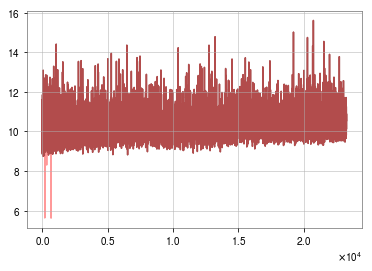

In [5]:
print(len(ln_weights_07))
print(len(ln_weights_10))
print(len(ln_weights_15))

plt.plot(ln_weights_07,color='k',alpha=0.5)
plt.plot(ln_weights_15,color='red',alpha=0.4)
#plt.plot(ln_weights_10,color='yellow',alpha=0.3)

In [11]:
#weightsLIGO_07 = np.exp(ln_weights_07)
#keep_07 = weightsLIGO_07 > np.random.uniform(0, max(weightsLIGO_07), weightsLIGO_07.shape)
#print(keep_07==True)
#LIGO_GW190412_z07.posterior = LIGO_GW190412_z07.posterior[keep_07]

#weightsLIGO_10 = np.exp(ln_weights_10)
#print(weightsLIGO_10)
#keep_samp10 = weightsLIGO_10 > np.random.uniform(0, max(weightsLIGO_10), weightsLIGO_10.shape)
#print(np.shape(keep_samp10))
#copy_LIGO_GW190412.posterior=copy_LIGO_GW190412.posterior[keep_samp10]

weightsLIGO_15 = np.exp(ln_weights_15)
keep_samp15 = weightsLIGO_15 > np.random.uniform(0, max(weightsLIGO_15), weightsLIGO_15.shape)
LIGO_GW190412_z15.posterior = LIGO_GW190412_z15.posterior[keep_samp15]

#logger.info("Rejection sampling resulted in {} samples".format(len(LIGO_GW190412_z07.posterior)))
#logger.info("Rejection sampling resulted in {} samples".format(len(copy_LIGO_GW190412.posterior)))
logger.info("Rejection sampling resulted in {} samples".format(len(LIGO_GW190412_z15.posterior)))

10:57 bilby INFO    : Rejection sampling resulted in 179 samples


In [12]:
Acc_GW190412 = bilby.result.read_in_result(filename='../GW190412/nonAcc/outdir/nonacc_prior_GW190412_result.json')
Unaltered_LIGO_GW190412 = bilby.result.read_in_result(filename='../GW190412/null/outdir/std_prior_GW190412_result.json')


Quantiles:
[(0.05, 14.915570016988394), (0.95, 15.424699902765383)]
Quantiles:
[(0.05, 0.2051932239216763), (0.95, 0.37329737993927853)]
Quantiles:
[(0.05, 0.1536800387538827), (0.95, 0.2998477028706684)]


/THEORY/USERS/swetha.bhagwat/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Quantiles:
[(0.05, 14.847321486962374), (0.95, 15.28177959931497)]
Quantiles:
[(0.05, 0.4704284348933797), (0.95, 0.9364318732739824)]
Quantiles:
[(0.05, -0.0035887333135099344), (0.95, 0.003890187971654758)]
Quantiles:
[(0.05, 14.904392310503916), (0.95, 15.524527251836432)]
Quantiles:
[(0.05, 0.20860026753677136), (0.95, 0.35785586621150733)]
Quantiles:
[(0.05, 0.14596064211063906), (0.95, 0.30478398490403424)]
Quantiles:
[(0.05, 14.974272850815384), (0.95, 15.465928470875918)]
Quantiles:
[(0.05, 0.21142346203378784), (0.95, 0.35547292999055824)]
Quantiles:
[(0.05, 0.15905508694448026), (0.95, 0.3112942760568528)]
Quantiles:
[(0.05, 14.942192435306708), (0.95, 15.487932983532499)]
Quantiles:
[(0.05, 0.21817775712185927), (0.95, 0.41751690822177046)]
Quantiles:
[(0.05, 0.11260505528244522), (0.95, 0.3101706590791398)]


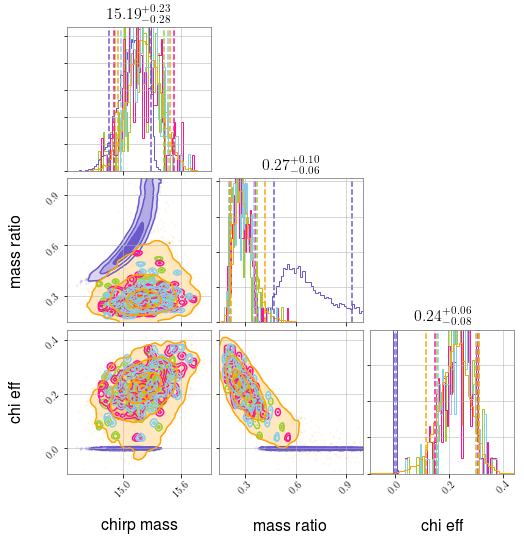

In [13]:
figzcutoff=copy_LIGO_GW190412.plot_corner(filename="Plot_Store/copy_LIGO_GW190412z10.png",quantiles=[0.05,0.95],smooth=True,verbose=True,parameters=["chirp_mass", "mass_ratio", "chi_eff"], show_titles=False, scale_hist=False, color='yellowgreen')
Acc_GW190412.plot_corner(filename="Plot_Store/copy_LIGO_GW190412z10.png",fig=figzcutoff,quantiles=[0.05,0.95],smooth=True,verbose=True,parameters=["chirp_mass", "mass_ratio", "chi_eff"], show_titles=False, scale_hist=False, color='slateblue')
LIGO_GW190412_z07.plot_corner(filename="Plot_Store/copy_LIGO_GW190412z10.png",fig=figzcutoff,quantiles=[0.05,0.95],smooth=True,verbose=True,parameters=["chirp_mass", "mass_ratio", "chi_eff"], show_titles=False, scale_hist=False, color='deeppink')
LIGO_GW190412_z15.plot_corner(filename="Plot_Store/copy_LIGO_GW190412z10.png",fig=figzcutoff,quantiles=[0.05,0.95],smooth=True,verbose=True,parameters=["chirp_mass", "mass_ratio", "chi_eff"], show_titles=False, scale_hist=False, color='skyblue')
Unaltered_LIGO_GW190412.plot_corner(filename="Plot_Store/copy_LIGO_GW190412z10.png",fig=figzcutoff,quantiles=[0.05,0.95],smooth=True,verbose=True,parameters=["chirp_mass", "mass_ratio", "chi_eff"], show_titles=False, scale_hist=False, color='orange')
